In [1]:
# Load FrameWork and Layer module

import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np

## Seq2Seq Structure

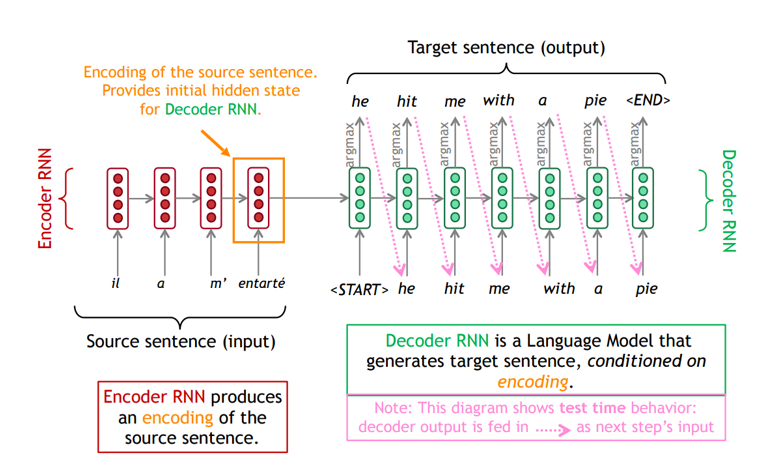

출처 : https://blog.naver.com/PostView.nhn?blogId=winddori2002&logNo=222001331899&parentCategoryNo=&categoryNo=32&viewDate=&isShowPopularPosts=false&from=postView

In [2]:
## Making Word2Index for tokenize

def Make_Word2Index(ctxt : list):
  word2index = dict()
  words = []
  if type(ctxt) == list:
    for text in ctxt:
      for word in text.split(" "):
        words.append(word)
  else :
    for word in ctxt.split(" "):
      words.append(word)

### word2index need <sos> and <eos> tokens
  word2index['<sos>'] = 0
  word2index['<eos>'] = 1
  for index, word in enumerate(list(set(words))):
    word2index[word] = index+2

  return word2index

## Tokenize function  
def tokenize(text, word2index): # -> input = text, word2index from above function
  tokens = []
  for word in text.split(" "):
    tokens.append(word2index[word])

  return tokens

In [3]:
""" Do Tokenizing """

## ctxt Example
ctxt = [
              '신은 항상 우리가 하는 말을 듣고 있다 따라서 마음속으로 하는 혼잣말에도 주의하라',
              '가장 귀중한 사랑의 가치는 희생과 헌신이다',
              '양초는 남을 밝게 해 주며 자신을 소비한다',
              '하루에 3시간을 걸으면 7년 후에 지구를 한바퀴 돌 수 있다',
              '먼저핀꽃은 먼저진다 남보다 먼저 공을 세우려고 조급히 서둘것이 아니다'
]
## Make word2index
word2index = Make_Word2Index(ctxt)

src =  ctxt[2]
tgt = '<sos> '+ ctxt[2] + ' <eos>'
## Tokenizing text
src = tokenize(src, word2index)
tgt = tokenize(tgt, word2index)

## List needs to be transformed into LongTensor for calculating Embedding, Not FloatTensor
src = torch.LongTensor([src])
tgt = torch.LongTensor([tgt])

print("--- Before embedding ---")
# print("input :\n", src)
# print("output :\n", tgt)
print("Size of tgt : ", tgt.size())
print("Size of src : ", src.size())

--- Before embedding ---
Size of tgt :  torch.Size([1, 9])
Size of src :  torch.Size([1, 7])


In [4]:
""" Init State """

### Default Setting
h_dim = 128  # hidden_dimension
input_size = len(word2index)  # Dimension of input meaning size of word2index
output_size = len(word2index)
emb_dim = 64

### Word Embedding with embedding layer
embedder_encoder = nn.Embedding(input_size, emb_dim)  # input : (batch_size, sequence_length) -> output : (batch_size, sequence_length, embedding_dim)
embedder_decoder = nn.Embedding(output_size, emb_dim)  # input : (batch_size, sequence_length) -> output : (batch_size, sequence_length, embedding_dim)

input = embedder_encoder(src)
output = embedder_decoder(tgt)

print("--- After embedding ---")
print("size of input :",input.size())
# print("input :\n",input)
print("size of output :",output.size())
# print("output :\n",output)

--- After embedding ---
size of input : torch.Size([1, 7, 64])
size of output : torch.Size([1, 9, 64])


## Express the above process in class

In [5]:
""" Make Encoder with LSTM (class) """

class Encoder(nn.Module):
  def __init__(self, input_size, h_dim, emb_dim):
    super(Encoder, self).__init__()

    self.embedding = nn.Embedding(input_size, emb_dim)
    self.lstm = nn.LSTM(input_size = emb_dim, hidden_size = h_dim, batch_first = True)
    self.drop = nn.Dropout()

  def forward(self, x):
    emb = self.drop(self.embedding(x))
    _, (hidden_state, cell_state) = self.lstm(emb)
    
    return hidden_state, cell_state

In [6]:
""" Make Decoder with LSTM (class) """

class Decoder(nn.Module):
  def __init__(self, output_size, h_dim, emb_dim):
    super(Decoder, self).__init__()

    self.embedding = nn.Embedding(output_size, emb_dim)
    self.lstm = nn.LSTM(input_size = emb_dim, hidden_size = h_dim, batch_first = True)
    self.drop = nn.Dropout()
    self.fc = nn.Linear(h_dim, output_size)

  def forward(self, x, hidden_state, cell_state):
    emb = self.drop(self.embedding(x))
    emb = emb.unsqueeze(1)

    result,(hidden_state, cell_state) = self.lstm(emb,\
                              (hidden_state, cell_state))
    result = self.fc(result)
    
    return result, hidden_state, cell_state

In [7]:
""" Seq2Seq with Encoder and Decoder class (class) """

class Seq2Seq(nn.Module):
  def __init__(self, input_size, output_size, h_dim, emb_dim, teacher_forcing=0.5):
    super(Seq2Seq,self).__init__()
   
    self.output_size = output_size
    self.encoder = Encoder(input_size, h_dim, emb_dim)
    self.decoder = Decoder(output_size, h_dim, emb_dim)
    self.teacher_forcing = teacher_forcing

  def forward(self, src, tgt):
    hidden_state, cell_state = self.encoder(src)
    
    tgt_len = tgt.size(1)
    result = torch.zeros((tgt.size(0), tgt_len-1, self.output_size))
    input = tgt[:,0]

    for i in range(1,tgt_len):
      output, hidden_state, cell_state = self.decoder(input, hidden_state, cell_state)
      result[:,i-1,:] = output
      top1 = output.argmax(2)

      if self.teacher_forcing > random.random() :
        input = torch.LongTensor([top1])
      else:
        input = tgt[:,i]
    
    return result

In [8]:
""" Make Seq2Seq and Excute """

### Seq2Seq class
seq2seq = Seq2Seq(input_size,output_size,h_dim,emb_dim)

### Perform model 
results = seq2seq(src, tgt)

print("Size of Results Before Processing :",results.size())
print("Size of Results After Processing :", results.argmax(dim =2).size())
print("Results : \n", results.argmax(dim =2))

Size of Results Before Processing : torch.Size([1, 8, 44])
Size of Results After Processing : torch.Size([1, 8])
Results : 
 tensor([[ 8, 29,  8, 27, 27,  6, 27, 41]])
